# Data processing 
from initial_micro_data_wrangling

In [75]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat

In [52]:
arctic_nc = "data/arctic_mmp.nc"
arctic_dataset = Dataset(arctic_nc)
arctic_ds = xr.open_dataset(arctic_nc)

In [53]:
arctic_ds

<xarray.Dataset>
Dimensions:          (length_t: 93, single: 1, length_tm: 9, length_c: 18,
                      length_o: 52, length_i: 3, profiles: 871, depth: 1201)
Dimensions without coordinates: length_t, single, length_tm, length_c,
                                length_o, length_i, profiles, depth
Data variables:
    title            (length_t, single) |S1 ...
    time             (length_tm, single) |S1 ...
    chief_scientist  (length_c, single) |S1 ...
    data_originator  (length_o, single) |S1 ...
    institution      (length_i, single) |S1 ...
    LATITUDE         (profiles, single) float64 ...
    LONGITUDE        (profiles, single) float64 ...
    TIME             (profiles, single) float64 ...
    EPSILON          (profiles, depth) float64 ...
    PRESSURE         (depth, single) float64 ...
    PSAL             (profiles, depth) float64 ...
    TEMPERATURE      (profiles, depth) float64 ...

Text(0.5, 1.0, 'Mean temperature with depth')

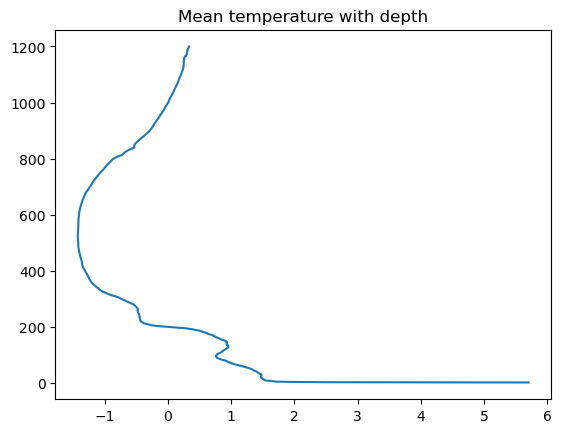

In [54]:
plt.plot(arctic_ds.TEMPERATURE.mean(axis=0),arctic_ds.depth)
plt.title("Mean temperature with depth")

In nc dataset, can find time, lat, lon, epsilon, pressure, psal, temperature.
dimensions for this dataset are lengths, profiles and depth

Text(0.5, 1.0, 'Pressure with depth')

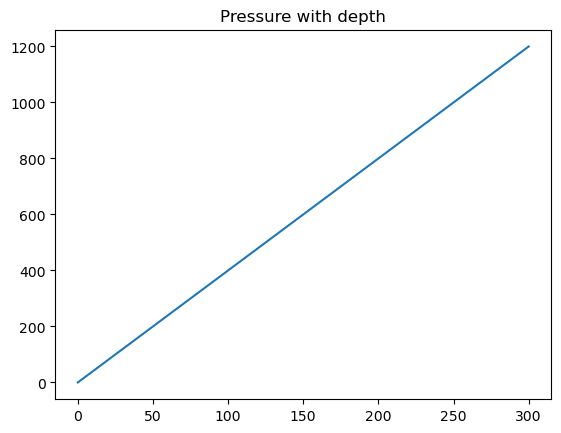

In [55]:
plt.plot(arctic_ds.PRESSURE,arctic_ds.depth)
plt.title("Pressure with depth")

Text(0.5, 1.0, 'Mean temperature, salinity and epsilon with depth')

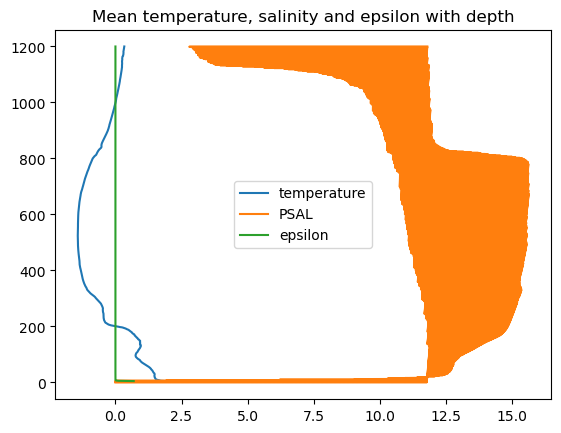

In [56]:
plt.plot(arctic_ds.TEMPERATURE.mean(axis=0),arctic_ds.depth, label = "temperature")
plt.plot(arctic_ds.PSAL.mean(axis=0),arctic_ds.depth, label = "PSAL")
plt.plot(arctic_ds.EPSILON.mean(axis=0),arctic_ds.depth, label = "epsilon")
#plt.plot(arctic_ds.PRESSURE.mean(axis=0),arctic_ds.depth)

plt.legend()
plt.title("Mean temperature, salinity and epsilon with depth")

Text(0.5, 1.0, 'Mean temperature, salinity and epsilon with depth')

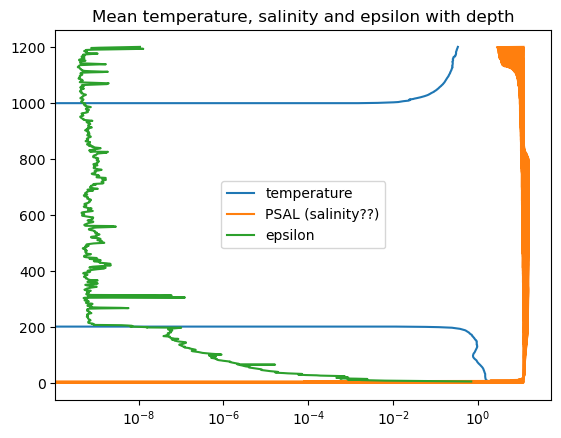

In [57]:
plt.plot(arctic_ds.TEMPERATURE.mean(axis=0),arctic_ds.depth, label = "temperature")
plt.plot(arctic_ds.PSAL.mean(axis=0),arctic_ds.depth, label = "PSAL (salinity??)")
plt.plot(arctic_ds.EPSILON.mean(axis=0),arctic_ds.depth, label = "epsilon")
#plt.plot(arctic_ds.PRESSURE.mean(axis=0),arctic_ds.depth)

plt.legend()
plt.xscale('log')
plt.title("Mean temperature, salinity and epsilon with depth")

## Omit all NaNs

In [64]:
# TO DO: verify this mask is correct
mask = (np.isnan(arctic_ds.TEMPERATURE) | np.isnan(arctic_ds.PSAL) | np.isnan(arctic_ds.EPSILON))
mask

<xarray.DataArray (profiles: 871, depth: 1201)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Dimensions without coordinates: profiles, depth

In [59]:
arctic_ds['TEMPERATURE'] = xr.where(mask,np.nan,arctic_ds.TEMPERATURE)
arctic_ds['PSAL'] = xr.where(mask,np.nan,arctic_ds.PSAL)
arctic_ds['EPSILON'] = xr.where(mask,np.nan,arctic_ds.EPSILON)


In [ ]:
mask = 1-(np.isnan(ds1.0.values) | np.isnan(ds2.0.values) | np.isnan(ds3.0.values))
# Make sure there are no nans
mask = np.isnan(arctic_ds.TEMPERATURE)*np.isnan(arctic_ds.PSAL)*np.isnan(arctic_ds.EPSILON)
print(mask)
# ds['pot_temp'] = xr.where(mask,np.nan,ds.pot_temp)
ds['temp'] = xr.where(mask,np.nan,ds.temp)
ds['salt'] = xr.where(mask,np.nan,ds.salt)
ds['eps'] = xr.where(mask,np.nan,ds.eps)

In [28]:
# trace back depth as a variable from pressure (how useful?)
arctic_ds["z"] = -arctic_ds.PRESSURE # pressure in dbar to z

## Add potential temperature

Text(0.5, 1.0, 'Mean potential temperature with depth')

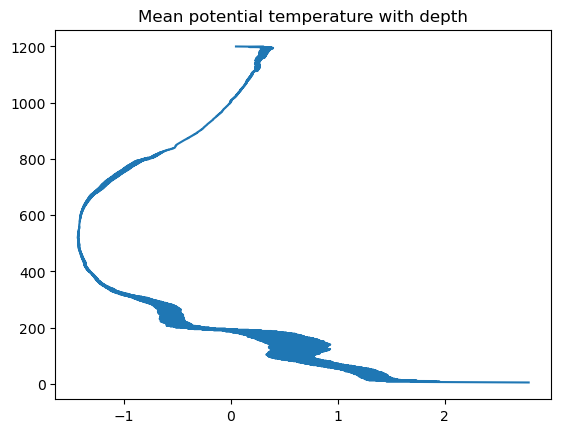

In [65]:
arctic_ds['pot_temp'] = gsw.conversions.pt0_from_t(arctic_ds.PSAL,arctic_ds.TEMPERATURE,arctic_ds.PRESSURE)
plt.plot(arctic_ds.pot_temp.mean(axis=0),arctic_ds.depth)
plt.title("Mean potential temperature with depth")

## Calculate height above bottom

In [ ]:
# depth of bathymetry
Nprof = ds.lat.shape[0]
depth = np.zeros(Nprof)
for i in tqdm(range(Nprof)):
    microlon = ds.lon[i].values
    microlat = ds.lat[i].values
    depth[i] = dsbathy.elevation.sel(lon=microlon,lat=microlat,method='nearest')
ds['depth'] = ds.lat.copy(data=depth)

In [ ]:
# Define height above bottom
ds['hab'] = ds.z - ds.depth
# Correct for where profiles might have negative hab
ds['hab'] = xr.where((ds.hab < 0) & (~np.isnan(ds.pot_temp)), 0, ds.hab)
# Make hab nan where there's no data
ds['hab'] = xr.where(np.isnan(ds.pot_temp),np.nan,ds.hab)

## derivatives

In [66]:
arctic_ds["dTdz"] = arctic_ds.TEMPERATURE.differentiate('depth')
arctic_ds['dSdz'] = arctic_ds.PSAL.differentiate('depth')
#arctic_ds['N2'] = -9.8/1027*ds2.gamma.differentiate('z')


Text(0.5, 1.0, 'Mean sailinty derivative with depth')

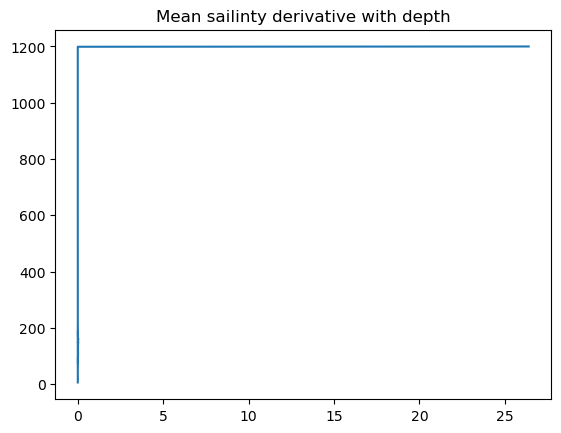

In [67]:
plt.plot(arctic_ds.dSdz.mean(axis=0),arctic_ds.depth)
plt.title("Mean sailinty derivative with depth")

Text(0.5, 1.0, 'Mean temperature derivative with depth')

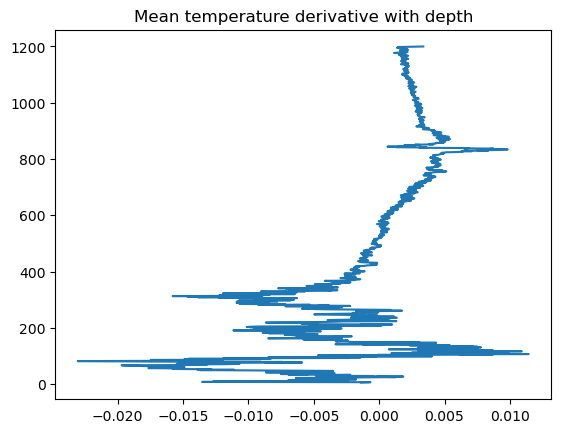

In [68]:
plt.plot(arctic_ds.dTdz.mean(axis=0),arctic_ds.depth)
plt.title("Mean temperature derivative with depth")

In [53]:
# check to see if any profiles are dodgy!!!
# make jupyter notebook for that
arctic_ds.profiles

<xarray.DataArray 'profiles' (profiles: 871)>
array([  0,   1,   2, ..., 868, 869, 870])
Dimensions without coordinates: profiles

## Calculate gamma

In [69]:
gamma_ds = arctic_ds.copy()

In [77]:
import gamma_GP_from_SP_pt

ModuleNotFoundError: No module named 'gamma_GP_from_SP_pt'

In [76]:
loadmat('gamma_GP_from_SP_pt.m')

ValueError: Unknown mat file type, version 116, 114

In [73]:
[latmesh, Zmesh]=np.meshgrid(gamma_ds.LATITUDE,gamma_ds.depth);
[lonmesh, Zmesh]=np.meshgrid(gamma_ds.LONGITUDE,gamma_ds.depth);

In [74]:
gamma = gamma_GP_from_SP_pt(gamma_ds.PSAL,gamma_ds.TEMPERATURE,gamma_ds.PRESSURE,lonmesh,latmesh)

NameError: name 'gamma_GP_from_SP_pt' is not defined

In [52]:
from xarray import meshgrid

ImportError: cannot import name 'meshgrid' from 'xarray' (/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/xarray/__init__.py)

In [51]:
[latmesh, Pmesh]=meshgrid(lat,pressure);
[lonmesh, Pmesh]=meshgrid(lon,pressure);

gamma = gamma_GP_from_SP_pt(S,T,Pmesh,lonmesh,latmesh);

NameError: name 'meshgrid' is not defined

## Data values

In [34]:
arctic_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): single(1), length_t(93), length_tm(9), length_c(18), length_o(52), length_i(3), profiles(871), depth(1201)
    variables(dimensions): |S1 title(length_t, single), |S1 time(length_tm, single), |S1 chief_scientist(length_c, single), |S1 data_originator(length_o, single), |S1 institution(length_i, single), float64 LATITUDE(profiles, single), float64 LONGITUDE(profiles, single), float64 TIME(profiles, single), float64 EPSILON(profiles, depth), float64 PRESSURE(depth, single), float64 PSAL(profiles, depth), float64 TEMPERATURE(profiles, depth)
    groups: 